# DQN on the CartPole problem
> Implemented the DQN algorithm to solve a classic control problem, the CartPole.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/chart-preview.png

# The CartPole problem

As the image below shows, the goal of the agent is to balance a verticle rod on the top of the car. This position is unstable and that is the main reason for the difficulty.

<img src="https://drive.google.com/uc?export=download&id=1wiFksyB3-mcirfdZEvrT2DPD7SBEjye2" >

The problem is solved if the average of the agent's scores is greater than 195 gathered in 100 episodes.
The agent receives reward 1 in each timestep until the psoition of the rod is correct (not inclined too far away from the vertical position).
The length of one episode is 200 time steps. Therefore the possible maximum score is 200.

The state is low dimensional and cosists of:
* position 
* velocity
* angle 
* angular velocity

Further details can be found on OpenAI gym's webpage: [Leader Board](https://github.com/openai/gym/wiki/CartPole-v0)

# Imports

In [ ]:
%matplotlib inline
%tensorflow_version 1.x
import matplotlib.pyplot as plt
import gym 
from gym.wrappers import Monitor
import numpy as np
import random
from enum import Enum
from skimage import transform as trf
from keras.models import Sequential # Keras: highlevel API above dnn libraries (tendorflow, cntr, theano)
from keras.layers import Dense, Convolution2D, Flatten
from keras.optimizers import Adam, SGD, RMSprop

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
class Optimizer(Enum): # Enum, Makes easier to try different optimizers
    ADAM = 1
    RMSPROP = 2
    SGD = 3

In [ ]:
# The implementation of DQN.
class Dqn:
    
    def __init__(self, params):         
        self.env = None                       # The environment where the RL agent will learn.
        self.buffer_size = params.buf_size    # The maximum size of the experience replay.
        self.batch_size = params.batch        # Batch size during training.
        self.epoch = params.epoch             # For one training cycle, the number epoch on a batch.
        self.max_episode = params.max_ep      # The number of episodes for training.
        self.eps0 = params.eps                # The starting value of epsilon in the epsilon-greedy policy.
        self.gamma = params.gamma             # Discounting factor.
        self.C = params.C                     # Frequency of synchronizing the frozen network.
        self.train_freq = params.train_freq   # Update frequency for the not frozen network.
        self.eval_freq = params.eval_freq     # Evaluation frequency.
        self.net = params.net                 # The description of the network. List of tuples. A tuple: (number of units, activation)
        self.lr = params.lr                   # learning rate
        self.opt = params.opt                 # Optimizer.

        self.q_cont, self.q_frzn = None, None # two networks for training: continuously updated and frozen

        self.buffer = []  # experience replay
        
        self.env = gym.make('CartPole-v0')
        self.env.reset()
        self.q_cont, self.q_frzn = self._init_models()
    
    # ------------------------------------------------------
    # functions for inicialization
    
    def _init_optimizer(self):

        optz = None
        if self.opt == Optimizer.ADAM:
            optz = Adam(self.lr)
        elif self.opt == Optimizer.SGD:
            optz = SGD(self.lr)
        elif self.opt == Optimizer.RMSPROP:
            optz = RMSprop(self.lr)

        return optz

    # The network builds up from Dense layers (similar to the fully connected)
    def _init_models(self):
        
        def build(strc):
            # strc - list of tuples
            # each tuple contains: number of nodes in the dense layer, activation function name (e.g.: 'relu')
            # ----- implement this -----
            q = Sequential()  # ----- create a sequential model -----
            q.add(Dense(units=strc[0][0],activation=strc[0][1],input_shape=(4,))) # ----- add a dense layer with input_shape 4 (4 frames will be stacked) -----
            # use the strc for accessing the required parameters


            for i in range(1, len(strc)):
                q.add(Dense(units=strc[i][0],activation=strc[i][1]))
                # ----- add the remaining dense layers to the model


            optz = self._init_optimizer()
            # compile the model with an appropriate loss function
            q.compile(optimizer=optz, loss='mean_squared_error')

            return q

        q_cont = build(self.net)  # continuously updated network (Q-function)
        q_frzn = build(self.net)  # frozen network

        q_cont.set_weights(q_frzn.get_weights())  # synchronization

        return q_cont, q_frzn

    def _init_buffer(self, number):
        # gathers 'number' pieces of experiences randomly
        # ----- study and undertand this piece of code carefully -----
        exps = []
        obs, rw, done, _ = self.env.step(0)
        for _ in range(number):

            if done:
                obs = self.env.reset()

            action = self.env.action_space.sample()  # sampling random actions from the environment
            obs_next, rw, done, _ = self.env.step(action)  # taking the step and observe the results
            exps.append((obs, rw, action, done, obs_next))  # we append a new experience
            obs = obs_next

        self.append(exps)  # you will implement this function
    
    def close(self):
        self.env.close()

    def train_function(self):
        
        # initializing experience replay with random experiences
        self._init_buffer(self.batch_size)

        print("Initialization was finished.")
        print("Training was started.")

        ep_id = 1
        cntr = 0
        eval_permitted = True
        rtn = 0
        exps = []
        
        ep_ids = []
        returns = []

        eps = self.eps0
        self.env.reset()
        obs, _, done, _ = self.env.step(0)

        while ep_id < self.max_episode:

            cntr += 1

            if done:
                if ep_id % 10 == 0:
                    print('Episode Id: ' + str(ep_id) + ' Return during training: ' + str(rtn))
                rtn = 0
                ep_id += 1
                eval_permitted = True
                obs = self.env.reset() # when an episode ends (done = True) the environment is reseted
            
            action = self.select_action_epsilon(state=obs, eps=eps)  # ---- select the next action with epsilon greedy -----

            obs_next, rw, done, _ = self.env.step(action)  # ----- take a new step with the environment -----
            rtn += rw
            
            if done:
                if rtn < 180:
                    rw = -1
                    obs_next *= 0.0
                    obs *= 0.0
                elif rtn >= 180:
                    rw = 100

            exps.append((obs, rw, action, done, obs_next))
            obs = obs_next

            if cntr % 128 == 0:
                self.append(exps)
                exps.clear()
            
            # training
            if  cntr % self.train_freq == 0:
                x, y = self.sample(number=self.batch_size)
                self.q_cont.fit(x=x, y=y, batch_size=self.batch_size, epochs=self.epoch, verbose=0) # ----- sample experiences from the replay then train q_cont with them
            
            # synchronizing the frozen network
            if cntr % self.C == 0:
                self.q_frzn.set_weights(self.q_cont.get_weights())

            # evaluating at the current stage of learning
            if ep_id % self.eval_freq == 0 and eval_permitted:
                r = self.evaluation()
                ep_ids.append(ep_id)
                returns.append(r)
                #print('EValuation at episode: ' + str(ep_id) + ' -> ' +  str(r))
                eval_permitted = False
                if r >= 185:
                    break
            
            # Decrasing the epsilon value for epsilon-greedy. Exploration -> exploitation
            eps = max(eps - 0.001, 0.01)

        print("Training was finished.")
        return ep_ids, returns

    def evaluation(self, video=False):
        
        orig_env = self.env
        if video:
            self.env = Monitor(orig_env, 'videos/cartpole', force=True)

        obs = self.env.reset()
        done = False
        rtn = 0
        ep_id = 0
        rtns = []

        while ep_id < 50:

            if done:
                rtns.append(rtn)
                rtn = 0
                ep_id += 1
                obs = self.env.reset()

            action = self.select_action_epsilon(obs, 0.01)
            obs, rw, done, _ = self.env.step(action)
            rtn += rw

        self.env = orig_env
        return np.mean(rtns)

    # ------------------------------------------------------
    # Functions for handling the experience replay

    def clear_buffer(self):
        self.buffer.clear()

    # The new experiences are added at the end of the buffer.
    # The too old experiences are deleted.
    def append(self, experiences):
        # experiences - list of experiences
        # ----- implement this -----
        
        # ----- check if appending the new set of experiences to the buffer has enough space -----
        if len(self.buffer) + len(experiences) > self.buffer_size:
            index = len(self.buffer) + len(experiences) - self.buffer_size
            # ----- if not, delete as many experiences as required -----
            del self.buffer[0:index]

        self.buffer += experiences  # finally we append the new experiences to the buffer

    def sample(self, number):
        exps = random.sample(self.buffer, number)    # experiences list
        obs = np.stack([x[0] for x in exps], axis=0) # numpy array is used by keras, for creating a batch observations should be stacked
        rws = np.stack([x[1] for x in exps]) # ----- do similar stacking for the rewards -----
        acts = np.stack([x[2] for x in exps]) # ----- implement this too -----
        dones = np.stack([x[3] for x in exps]) # ----- implement this too -----
        next_obs = np.stack([x[4] for x in exps], axis=0) # ----- implement this too -----

        q_vals = self.q_cont.predict(obs, batch_size=number) # ----- predict (forward execute) with q_cont on obs -----   # q_vals size should be: (batch_size, 2)
        fzn_q_vals = self.q_frzn.predict(next_obs, batch_size=number)  # ----- predict with q_frzn on next_obs -----
        
        # The action function is represented by a network.
        # The input of this network is the state, 
        # the output is the set of action-values
        # corresponding to the actions.
        # So the number of outputs is equal with the nunmber of actions.
        # In training we sample one transition at a time, therefore we have loss
        # for only one output (action) at a time.
        # But for training, we have to provide information for all of the outputs.
        # How can we solve this?
        sub_values = rws + np.max(fzn_q_vals, axis=1) * self.gamma * (1 - dones) # ----- calculate this according to the one-step return for Q-learning -----
        q_vals[list(range(number)), acts] = sub_values  # this will be the target during training

        x = obs.astype(dtype=np.float32)
        y = q_vals.astype(dtype=np.float32)

        return x, y

    # ------------------------------------------------------
    # Choosing an action

    # epsilon-greedy
    def select_action_epsilon(self, state, eps):  # state shape: (4) nunmpy array
        s = np.expand_dims(state, axis=0)
        max_idx = np.argmax(self.q_cont.predict(s, batch_size=1))
        if np.random.random() < 1 - eps:
            return max_idx
        return (max_idx + 1) % 2 # now we have only two actions

    # no epsilon-greedy
    def select_action(self, state):
        s = np.expand_dims(state, axis=0)
        return np.argmax(self.q_cont.predict(s, batch_size=1))

In [ ]:
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

# Experiments

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 22.0
Episode Id: 20 Return during training: 11.0
Episode Id: 30 Return during training: 14.0
Episode Id: 40 Return during training: 17.0
Episode Id: 50 Return during training: 30.0
Episode Id: 60 Return during training: 27.0
Episode Id: 70 Return during training: 53.0
Episode Id: 80 Return during training: 93.0
Episode Id: 90 Return during training: 12.0
Episode Id: 100 Return during training: 143.0
Episode Id: 110 Return during training: 151.0
Episode Id: 120 Return during training: 69.0
Episode Id: 130 Return during training: 121.0
Episode Id: 140 Return during training: 12.0
Episode Id: 150 Return during training: 144.0
Episode Id: 160 Return during training: 131.0
Episode Id: 170 Return during training: 131.0
Training was finished.


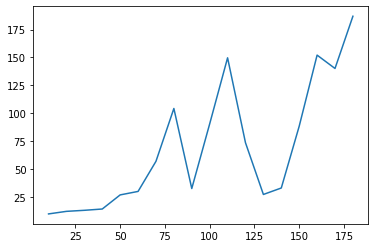

In [ ]:
# Running the training and evaluation
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

When defaults parameters doesnt converge.

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 33.0
Episode Id: 20 Return during training: 14.0
Episode Id: 30 Return during training: 14.0
Episode Id: 40 Return during training: 14.0
Episode Id: 50 Return during training: 32.0
Episode Id: 60 Return during training: 31.0
Episode Id: 70 Return during training: 46.0
Episode Id: 80 Return during training: 129.0
Episode Id: 90 Return during training: 84.0
Episode Id: 100 Return during training: 112.0
Episode Id: 110 Return during training: 200.0
Episode Id: 120 Return during training: 84.0
Episode Id: 130 Return during training: 132.0
Episode Id: 140 Return during training: 23.0
Episode Id: 150 Return during training: 127.0
Episode Id: 160 Return during training: 124.0
Episode Id: 170 Return during training: 107.0
Episode Id: 180 Return during training: 121.0
Episode Id: 190 Return during training: 114.0
Episode Id: 200 Return during training: 138.0
Episode Id: 210 Return during training: 151.0
Ep

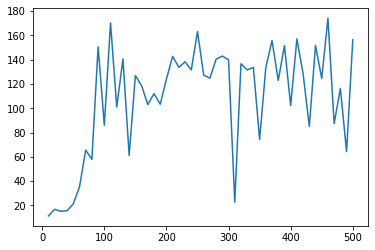

In [ ]:
pms = Parameters()

dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
print(dqn.evaluation(video=False))
dqn.close()   

Does it converge all the time?

Due to neural networks being in the picture leads to a bit of uncertainity as they are not deterministic. Hence its a mix of stable and unstable convergnence. It doesnt convrge all the time. Best we can do is find good hyperparameters and hope the whole system performs somewhat similar everytime while executing runs. There are cases when we experiment with same parameters sometimes it converges sometimes it doesnt.

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 10.0
Episode Id: 20 Return during training: 12.0
Episode Id: 30 Return during training: 9.0
Episode Id: 40 Return during training: 9.0
Episode Id: 50 Return during training: 9.0
Episode Id: 60 Return during training: 10.0
Episode Id: 70 Return during training: 9.0
Episode Id: 80 Return during training: 9.0
Episode Id: 90 Return during training: 11.0
Episode Id: 100 Return during training: 9.0
Episode Id: 110 Return during training: 9.0
Episode Id: 120 Return during training: 11.0
Episode Id: 130 Return during training: 13.0
Episode Id: 140 Return during training: 12.0
Episode Id: 150 Return during training: 12.0
Episode Id: 160 Return during training: 15.0
Episode Id: 170 Return during training: 12.0
Episode Id: 180 Return during training: 11.0
Episode Id: 190 Return during training: 17.0
Episode Id: 200 Return during training: 16.0
Episode Id: 210 Return during training: 18.0
Episode Id: 220 Retu

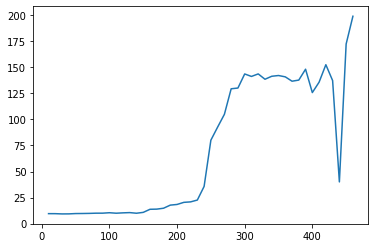

In [ ]:
pms = Parameters()
pms.epoch=3
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
print(dqn.evaluation(video=False))
dqn.close()   

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 16.0
Episode Id: 20 Return during training: 18.0
Episode Id: 30 Return during training: 39.0
Episode Id: 40 Return during training: 39.0
Episode Id: 50 Return during training: 101.0
Episode Id: 60 Return during training: 140.0
Episode Id: 70 Return during training: 119.0
Episode Id: 80 Return during training: 200.0
Episode Id: 90 Return during training: 148.0
Episode Id: 100 Return during training: 167.0
Episode Id: 110 Return during training: 200.0
Episode Id: 120 Return during training: 200.0
Training was finished.
189.92


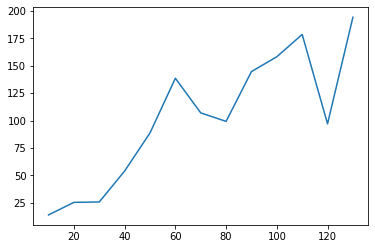

In [ ]:
pms = Parameters()
pms.epoch=10
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
print(dqn.evaluation(video=False))
dqn.close()  

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 26.0
Episode Id: 20 Return during training: 9.0
Episode Id: 30 Return during training: 9.0
Episode Id: 40 Return during training: 9.0
Episode Id: 50 Return during training: 9.0
Episode Id: 60 Return during training: 11.0
Episode Id: 70 Return during training: 12.0
Episode Id: 80 Return during training: 10.0
Episode Id: 90 Return during training: 25.0
Episode Id: 100 Return during training: 45.0
Episode Id: 110 Return during training: 48.0
Episode Id: 120 Return during training: 33.0
Episode Id: 130 Return during training: 37.0
Episode Id: 140 Return during training: 45.0
Episode Id: 150 Return during training: 34.0
Episode Id: 160 Return during training: 55.0
Episode Id: 170 Return during training: 98.0
Episode Id: 180 Return during training: 125.0
Episode Id: 190 Return during training: 88.0
Episode Id: 200 Return during training: 146.0
Episode Id: 210 Return during training: 31.0
Training was fi

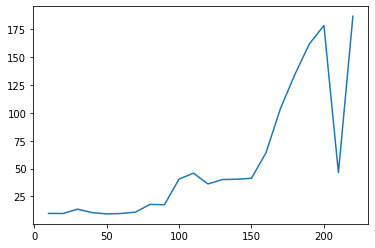

In [ ]:
pms = Parameters()
pms.batch=64
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
print(dqn.evaluation(video=False))
dqn.close()   

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 21.0
Episode Id: 20 Return during training: 10.0
Episode Id: 30 Return during training: 11.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 28.0
Episode Id: 60 Return during training: 59.0
Episode Id: 70 Return during training: 200.0
Training was finished.
193.5


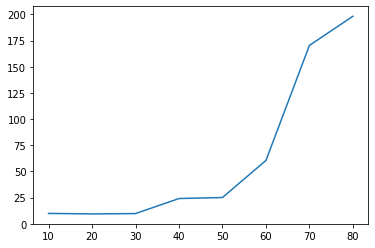

In [ ]:
pms = Parameters()
pms.batch=512
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
print(dqn.evaluation(video=False))
dqn.close() 

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 8.0
Episode Id: 20 Return during training: 13.0
Episode Id: 30 Return during training: 11.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 9.0
Episode Id: 60 Return during training: 11.0
Episode Id: 70 Return during training: 9.0
Episode Id: 80 Return during training: 9.0
Episode Id: 90 Return during training: 9.0
Training was finished.
9.28


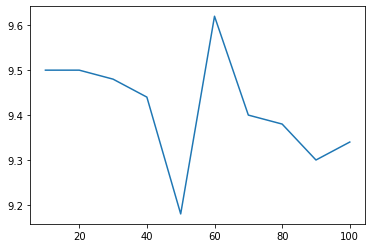

In [ ]:
pms = Parameters()
pms.max_ep = 100
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
print(dqn.evaluation(video=False))
dqn.close()  

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 9.0
Episode Id: 20 Return during training: 11.0
Episode Id: 30 Return during training: 10.0
Episode Id: 40 Return during training: 8.0
Episode Id: 50 Return during training: 10.0
Episode Id: 60 Return during training: 11.0
Episode Id: 70 Return during training: 9.0
Episode Id: 80 Return during training: 10.0
Episode Id: 90 Return during training: 10.0
Episode Id: 100 Return during training: 10.0
Episode Id: 110 Return during training: 9.0
Episode Id: 120 Return during training: 10.0
Episode Id: 130 Return during training: 11.0
Episode Id: 140 Return during training: 10.0
Episode Id: 150 Return during training: 9.0
Episode Id: 160 Return during training: 10.0
Episode Id: 170 Return during training: 8.0
Episode Id: 180 Return during training: 10.0
Episode Id: 190 Return during training: 9.0
Episode Id: 200 Return during training: 9.0
Episode Id: 210 Return during training: 9.0
Episode Id: 220 Return

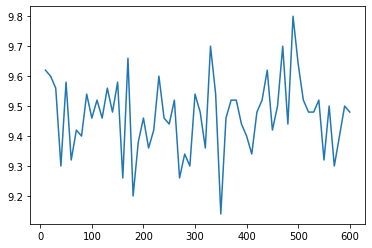

In [ ]:
pms = Parameters()
pms.max_ep = 600
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
print(dqn.evaluation(video=False))
dqn.close() 

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 10.0
Episode Id: 20 Return during training: 11.0
Episode Id: 30 Return during training: 11.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 9.0
Episode Id: 60 Return during training: 10.0
Episode Id: 70 Return during training: 11.0
Episode Id: 80 Return during training: 11.0
Episode Id: 90 Return during training: 8.0
Episode Id: 100 Return during training: 9.0
Episode Id: 110 Return during training: 10.0
Episode Id: 120 Return during training: 13.0
Episode Id: 130 Return during training: 14.0
Episode Id: 140 Return during training: 61.0
Episode Id: 150 Return during training: 138.0
Episode Id: 160 Return during training: 164.0
Episode Id: 170 Return during training: 143.0
Episode Id: 180 Return during training: 120.0
Episode Id: 190 Return during training: 200.0
Training was finished.
200.0


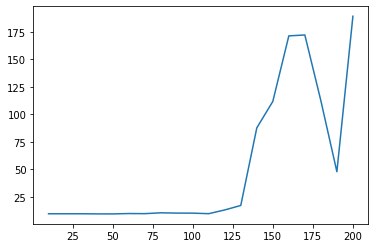

In [ ]:
pms = Parameters()

pms.eps =0.1
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
print(dqn.evaluation(video=False))
dqn.close()   

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 19.0
Episode Id: 20 Return during training: 16.0
Episode Id: 30 Return during training: 12.0
Episode Id: 40 Return during training: 18.0
Episode Id: 50 Return during training: 23.0
Episode Id: 60 Return during training: 66.0
Episode Id: 70 Return during training: 58.0
Episode Id: 80 Return during training: 54.0
Episode Id: 90 Return during training: 68.0
Training was finished.
200.0


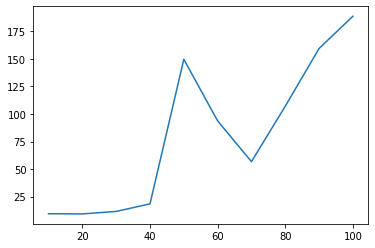

In [ ]:
pms = Parameters()

pms.eps =0.9
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
print(dqn.evaluation(video=False))
dqn.close() 

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 10.0
Episode Id: 20 Return during training: 10.0
Episode Id: 30 Return during training: 11.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 12.0
Episode Id: 60 Return during training: 11.0
Episode Id: 70 Return during training: 27.0
Episode Id: 80 Return during training: 27.0
Episode Id: 90 Return during training: 23.0
Episode Id: 100 Return during training: 21.0
Episode Id: 110 Return during training: 63.0
Episode Id: 120 Return during training: 104.0
Episode Id: 130 Return during training: 91.0
Episode Id: 140 Return during training: 139.0
Episode Id: 150 Return during training: 10.0
Episode Id: 160 Return during training: 125.0
Episode Id: 170 Return during training: 11.0
Episode Id: 180 Return during training: 8.0
Episode Id: 190 Return during training: 17.0
Episode Id: 200 Return during training: 16.0
Episode Id: 210 Return during training: 18.0
Episode Id:

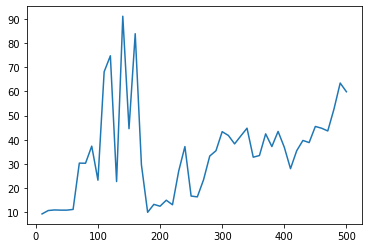

In [ ]:
pms = Parameters()

pms.gamma = 0.5

dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
print(dqn.evaluation(video=False))
dqn.close()   

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 16.0
Episode Id: 20 Return during training: 14.0
Episode Id: 30 Return during training: 10.0
Episode Id: 40 Return during training: 9.0
Episode Id: 50 Return during training: 9.0
Episode Id: 60 Return during training: 12.0
Episode Id: 70 Return during training: 13.0
Episode Id: 80 Return during training: 12.0
Episode Id: 90 Return during training: 12.0
Episode Id: 100 Return during training: 15.0
Episode Id: 110 Return during training: 12.0
Episode Id: 120 Return during training: 14.0
Episode Id: 130 Return during training: 97.0
Episode Id: 140 Return during training: 44.0
Episode Id: 150 Return during training: 68.0
Episode Id: 160 Return during training: 71.0
Episode Id: 170 Return during training: 115.0
Episode Id: 180 Return during training: 117.0
Episode Id: 190 Return during training: 123.0
Episode Id: 200 Return during training: 141.0
Episode Id: 210 Return during training: 10.0
Episode Id:

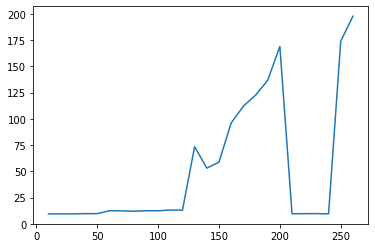

In [ ]:
pms = Parameters()

pms.C = 25
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
print(dqn.evaluation(video=False))
dqn.close()   

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 14.0
Episode Id: 20 Return during training: 11.0
Episode Id: 30 Return during training: 10.0
Episode Id: 40 Return during training: 11.0
Episode Id: 50 Return during training: 10.0
Episode Id: 60 Return during training: 9.0
Episode Id: 70 Return during training: 11.0
Episode Id: 80 Return during training: 21.0
Episode Id: 90 Return during training: 10.0
Episode Id: 100 Return during training: 31.0
Episode Id: 110 Return during training: 62.0
Episode Id: 120 Return during training: 24.0
Episode Id: 130 Return during training: 31.0
Episode Id: 140 Return during training: 33.0
Episode Id: 150 Return during training: 40.0
Training was finished.
200.0


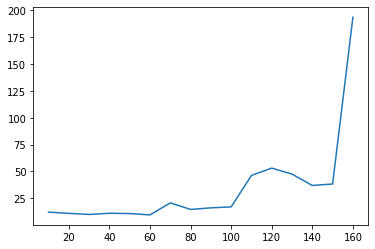

In [ ]:
pms = Parameters()

pms.C = 200
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
print(dqn.evaluation(video=False))
dqn.close()   

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 11.0
Training was finished.
190.18


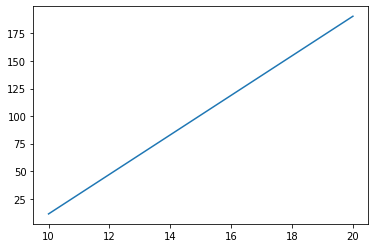

In [ ]:
pms = Parameters()

pms.lr = 0.001
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
print(dqn.evaluation(video=False))
dqn.close()  

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 17.0
Episode Id: 20 Return during training: 12.0
Episode Id: 30 Return during training: 13.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 9.0
Episode Id: 60 Return during training: 11.0
Episode Id: 70 Return during training: 10.0
Episode Id: 80 Return during training: 9.0
Episode Id: 90 Return during training: 8.0
Episode Id: 100 Return during training: 16.0
Episode Id: 110 Return during training: 10.0
Episode Id: 120 Return during training: 9.0
Episode Id: 130 Return during training: 12.0
Episode Id: 140 Return during training: 9.0
Episode Id: 150 Return during training: 31.0
Episode Id: 160 Return during training: 17.0
Episode Id: 170 Return during training: 16.0
Episode Id: 180 Return during training: 31.0
Episode Id: 190 Return during training: 10.0
Episode Id: 200 Return during training: 10.0
Episode Id: 210 Return during training: 32.0
Episode Id: 220 Re

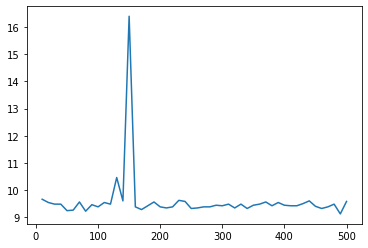

In [ ]:
pms = Parameters()

pms.lr = 0.1
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
print(dqn.evaluation(video=False))
dqn.close()  

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 10.0
Episode Id: 20 Return during training: 15.0
Episode Id: 30 Return during training: 14.0
Episode Id: 40 Return during training: 14.0
Episode Id: 50 Return during training: 18.0
Episode Id: 60 Return during training: 14.0
Episode Id: 70 Return during training: 15.0
Episode Id: 80 Return during training: 18.0
Episode Id: 90 Return during training: 17.0
Episode Id: 100 Return during training: 22.0
Episode Id: 110 Return during training: 64.0
Episode Id: 120 Return during training: 77.0
Episode Id: 130 Return during training: 75.0
Episode Id: 140 Return during training: 156.0
Episode Id: 150 Return during training: 134.0
Episode Id: 160 Return during training: 137.0
Episode Id: 170 Return during training: 162.0
Episode Id: 180 Return during training: 166.0
Episode Id: 190 Return during training: 185.0
Training was finished.
188.46


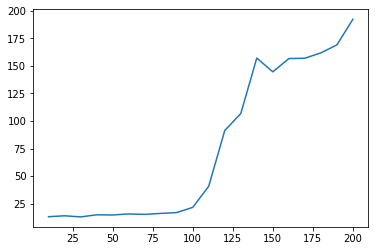

In [ ]:
pms = Parameters()

pms.opt = Optimizer.RMSPROP
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
print(dqn.evaluation(video=False))
dqn.close()  

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 39.0
Episode Id: 20 Return during training: 27.0
Episode Id: 30 Return during training: 10.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 9.0
Episode Id: 60 Return during training: 8.0
Episode Id: 70 Return during training: 10.0
Episode Id: 80 Return during training: 10.0
Episode Id: 90 Return during training: 11.0
Episode Id: 100 Return during training: 9.0
Episode Id: 110 Return during training: 8.0
Episode Id: 120 Return during training: 10.0
Episode Id: 130 Return during training: 9.0
Episode Id: 140 Return during training: 10.0
Episode Id: 150 Return during training: 10.0
Episode Id: 160 Return during training: 10.0
Episode Id: 170 Return during training: 10.0
Episode Id: 180 Return during training: 9.0
Episode Id: 190 Return during training: 10.0
Episode Id: 200 Return during training: 10.0
Episode Id: 210 Return during training: 9.0
Episode Id: 220 Retu

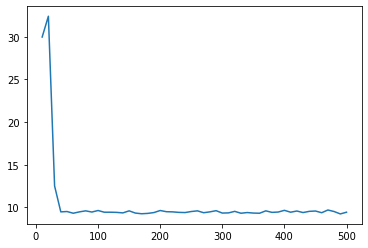

In [ ]:
pms = Parameters()

pms.opt = Optimizer.SGD
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
print(dqn.evaluation(video=False))
dqn.close()  

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 14.0
Episode Id: 20 Return during training: 12.0
Episode Id: 30 Return during training: 10.0
Episode Id: 40 Return during training: 11.0
Episode Id: 50 Return during training: 11.0
Episode Id: 60 Return during training: 24.0
Episode Id: 70 Return during training: 23.0
Episode Id: 80 Return during training: 39.0
Episode Id: 90 Return during training: 83.0
Episode Id: 100 Return during training: 187.0
Episode Id: 110 Return during training: 9.0
Episode Id: 120 Return during training: 94.0
Episode Id: 130 Return during training: 125.0
Training was finished.
200.0


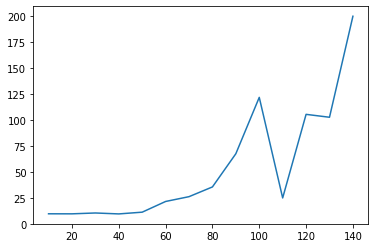

In [ ]:
pms = Parameters()

pms.buf_size = 2000
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
print(dqn.evaluation(video=False))
dqn.close()  

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 19.0
Episode Id: 20 Return during training: 11.0
Episode Id: 30 Return during training: 10.0
Episode Id: 40 Return during training: 9.0
Episode Id: 50 Return during training: 10.0
Episode Id: 60 Return during training: 12.0
Episode Id: 70 Return during training: 10.0
Episode Id: 80 Return during training: 11.0
Episode Id: 90 Return during training: 10.0
Episode Id: 100 Return during training: 10.0
Episode Id: 110 Return during training: 10.0
Episode Id: 120 Return during training: 10.0
Episode Id: 130 Return during training: 11.0
Episode Id: 140 Return during training: 9.0
Episode Id: 150 Return during training: 12.0
Episode Id: 160 Return during training: 10.0
Episode Id: 170 Return during training: 9.0
Episode Id: 180 Return during training: 9.0
Episode Id: 190 Return during training: 9.0
Episode Id: 200 Return during training: 10.0
Episode Id: 210 Return during training: 10.0
Episode Id: 220 Re

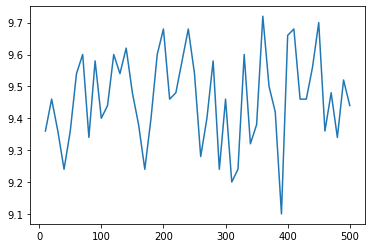

In [ ]:
pms = Parameters()

pms.buf_size = 6000
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
print(dqn.evaluation(video=False))
dqn.close() 

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 18.0
Episode Id: 20 Return during training: 14.0
Episode Id: 30 Return during training: 9.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 10.0
Episode Id: 60 Return during training: 10.0
Episode Id: 70 Return during training: 10.0
Episode Id: 80 Return during training: 11.0
Episode Id: 90 Return during training: 9.0
Episode Id: 100 Return during training: 10.0
Episode Id: 110 Return during training: 8.0
Episode Id: 120 Return during training: 9.0
Episode Id: 130 Return during training: 11.0
Episode Id: 140 Return during training: 10.0
Episode Id: 150 Return during training: 9.0
Episode Id: 160 Return during training: 8.0
Episode Id: 170 Return during training: 11.0
Episode Id: 180 Return during training: 11.0
Episode Id: 190 Return during training: 10.0
Episode Id: 200 Return during training: 11.0
Episode Id: 210 Return during training: 10.0
Episode Id: 220 Ret

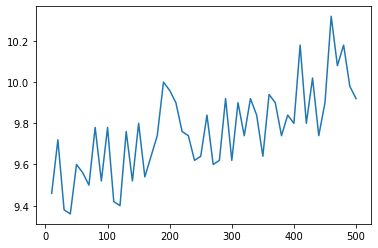

In [ ]:
pms = Parameters()

pms.net = [(128, 'relu'), (2, 'relu')]
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
print(dqn.evaluation(video=False))
dqn.close() 

### Question:

* What happens if you change the default parameters?

We first try changing the hyperparams in both directions less than defualt and then more than default.


*   For less epochs lead to slower convergence and more epochs leads to a bit faster convergence.
*   changes in batch sizes leads to nice results and doesnt vary much or maybe slightly.
*   changes in max_eps gives very bad results.
*   a lower ep 0.1 gives good convergence whereas higher eps gives faster convergence.
*   a lower gamma gives troubles for convergence.
*   changes in C doesnt bring a lot of change.
*   a very high lerning rate doesnt help much and it doesnt converge.
*   when it comes to choice of optimisers RMSprop gives fine results where SGD doesnt converge at all.
*   lower buffer size converges faster but with some disturbances and higher buffer size takes more time.
*   when we use a single layered network it doesnt converge.

In general what we observe is that things go unpredictable sometimes and convergence doesnt happen at all.

Instead of try changing parameters by hand i thought of implementing bayesian hyperparameter search and then interpreting the results. The intervals for search space were kept reasonable and optuna choose those parameters that maximised the returns coming from evaluation function.

# Optimisation

In [ ]:
!pip install optuna

In [ ]:
import optuna

[I 2021-01-19 14:37:14,799] A new study created in memory with name: no-name-513b41a0-7844-4046-b782-4949f2f5ba56
/usr/local/lib/python3.6/dist-packages/optuna/distributions.py:430: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains Optimizer.ADAM which is of type Optimizer.

/usr/local/lib/python3.6/dist-packages/optuna/distributions.py:430: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains Optimizer.RMSPROP which is of type Optimizer.

/usr/local/lib/python3.6/dist-packages/optuna/distributions.py:430: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains Optimizer.SGD which is of type Optimizer.



Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 9.0
Episode Id: 20 Return during training: 9.0
Episode Id: 30 Return during training: 9.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 8.0
Episode Id: 60 Return during training: 10.0
Episode Id: 70 Return during training: 11.0
Episode Id: 80 Return during training: 10.0
Episode Id: 90 Return during training: 10.0
Episode Id: 100 Return during training: 13.0
Episode Id: 110 Return during training: 11.0
Episode Id: 120 Return during training: 10.0
Episode Id: 130 Return during training: 10.0
Episode Id: 140 Return during training: 10.0
Episode Id: 150 Return during training: 10.0
Episode Id: 160 Return during training: 11.0
Episode Id: 170 Return during training: 12.0
Episode Id: 180 Return during training: 11.0
Episode Id: 190 Return during training: 9.0
Training was finished.


[I 2021-01-19 14:38:20,676] Trial 0 finished with value: 10.02 and parameters: {'buffer': 2000, 'batch': 64, 'max_ep': 200, 'eps': 0.16178705427228546, 'gamma': 0.8460512795534829, 'C': 75, 'lr': 0.013104808942779851, 'opt': <Optimizer.SGD: 3>}. Best is trial 0 with value: 10.02.


Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 27.0
Episode Id: 20 Return during training: 9.0
Episode Id: 30 Return during training: 13.0
Episode Id: 40 Return during training: 24.0
Episode Id: 50 Return during training: 25.0
Episode Id: 60 Return during training: 68.0
Episode Id: 70 Return during training: 47.0
Episode Id: 80 Return during training: 20.0
Episode Id: 90 Return during training: 88.0
Episode Id: 100 Return during training: 12.0
Episode Id: 110 Return during training: 72.0
Episode Id: 120 Return during training: 10.0
Episode Id: 130 Return during training: 58.0
Episode Id: 140 Return during training: 10.0
Episode Id: 150 Return during training: 98.0
Episode Id: 160 Return during training: 13.0
Episode Id: 170 Return during training: 17.0
Episode Id: 180 Return during training: 11.0
Episode Id: 190 Return during training: 26.0
Episode Id: 200 Return during training: 13.0
Episode Id: 210 Return during training: 99.0
Episode Id: 22

[I 2021-01-19 14:45:48,808] Trial 1 finished with value: 97.3 and parameters: {'buffer': 3000, 'batch': 64, 'max_ep': 400, 'eps': 0.3347880128133707, 'gamma': 0.5299536835694416, 'C': 125, 'lr': 0.0070861183784352196, 'opt': <Optimizer.RMSPROP: 2>}. Best is trial 1 with value: 97.3.


Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 23.0
Episode Id: 20 Return during training: 11.0
Episode Id: 30 Return during training: 12.0
Episode Id: 40 Return during training: 16.0
Episode Id: 50 Return during training: 15.0
Episode Id: 60 Return during training: 10.0
Episode Id: 70 Return during training: 30.0
Episode Id: 80 Return during training: 25.0
Episode Id: 90 Return during training: 18.0
Episode Id: 100 Return during training: 10.0
Episode Id: 110 Return during training: 12.0
Episode Id: 120 Return during training: 9.0
Episode Id: 130 Return during training: 66.0
Episode Id: 140 Return during training: 19.0
Episode Id: 150 Return during training: 10.0
Episode Id: 160 Return during training: 9.0
Episode Id: 170 Return during training: 51.0
Episode Id: 180 Return during training: 18.0
Episode Id: 190 Return during training: 10.0
Episode Id: 200 Return during training: 16.0
Episode Id: 210 Return during training: 16.0
Episode Id: 220

[I 2021-01-19 14:53:36,412] Trial 2 finished with value: 9.34 and parameters: {'buffer': 1000, 'batch': 64, 'max_ep': 800, 'eps': 0.28548258668638127, 'gamma': 0.6417336884904364, 'C': 50, 'lr': 0.07573568758723705, 'opt': <Optimizer.ADAM: 1>}. Best is trial 1 with value: 97.3.


Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 14.0
Episode Id: 20 Return during training: 10.0
Episode Id: 30 Return during training: 11.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 11.0
Episode Id: 60 Return during training: 13.0
Episode Id: 70 Return during training: 10.0
Episode Id: 80 Return during training: 10.0
Episode Id: 90 Return during training: 9.0
Episode Id: 100 Return during training: 9.0
Episode Id: 110 Return during training: 8.0
Episode Id: 120 Return during training: 11.0
Episode Id: 130 Return during training: 9.0
Episode Id: 140 Return during training: 10.0
Training was finished.


[I 2021-01-19 14:56:15,016] Trial 3 finished with value: 195.92 and parameters: {'buffer': 9000, 'batch': 512, 'max_ep': 600, 'eps': 0.34334144859441046, 'gamma': 0.7697185996632169, 'C': 75, 'lr': 0.047113595466760166, 'opt': <Optimizer.ADAM: 1>}. Best is trial 3 with value: 195.92.


Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 9.0
Episode Id: 20 Return during training: 11.0
Episode Id: 30 Return during training: 8.0
Episode Id: 40 Return during training: 9.0
Episode Id: 50 Return during training: 10.0
Episode Id: 60 Return during training: 11.0
Episode Id: 70 Return during training: 12.0
Episode Id: 80 Return during training: 11.0
Episode Id: 90 Return during training: 11.0
Episode Id: 100 Return during training: 9.0
Episode Id: 110 Return during training: 10.0
Episode Id: 120 Return during training: 10.0
Episode Id: 130 Return during training: 9.0
Episode Id: 140 Return during training: 8.0
Episode Id: 150 Return during training: 10.0
Episode Id: 160 Return during training: 13.0
Episode Id: 170 Return during training: 13.0
Episode Id: 180 Return during training: 12.0
Episode Id: 190 Return during training: 9.0
Episode Id: 200 Return during training: 12.0
Episode Id: 210 Return during training: 17.0
Episode Id: 220 Retu

[I 2021-01-19 15:14:41,119] Trial 4 finished with value: 39.74 and parameters: {'buffer': 9000, 'batch': 64, 'max_ep': 800, 'eps': 0.23790276869659102, 'gamma': 0.5686850013025211, 'C': 25, 'lr': 0.00718815974335307, 'opt': <Optimizer.SGD: 3>}. Best is trial 3 with value: 195.92.


Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 19.0
Episode Id: 20 Return during training: 13.0
Episode Id: 30 Return during training: 15.0
Episode Id: 40 Return during training: 9.0
Episode Id: 50 Return during training: 19.0
Episode Id: 60 Return during training: 30.0
Episode Id: 70 Return during training: 17.0
Episode Id: 80 Return during training: 9.0
Episode Id: 90 Return during training: 9.0
Episode Id: 100 Return during training: 14.0
Episode Id: 110 Return during training: 58.0
Episode Id: 120 Return during training: 13.0
Episode Id: 130 Return during training: 20.0
Episode Id: 140 Return during training: 62.0
Episode Id: 150 Return during training: 10.0
Episode Id: 160 Return during training: 19.0
Episode Id: 170 Return during training: 24.0
Episode Id: 180 Return during training: 11.0
Episode Id: 190 Return during training: 12.0
Episode Id: 200 Return during training: 68.0
Episode Id: 210 Return during training: 21.0
Episode Id: 220 

[I 2021-01-19 15:27:42,061] Trial 5 finished with value: 11.7 and parameters: {'buffer': 9000, 'batch': 256, 'max_ep': 600, 'eps': 0.11482560627364474, 'gamma': 0.5082179055608805, 'C': 100, 'lr': 0.014347162778323163, 'opt': <Optimizer.RMSPROP: 2>}. Best is trial 3 with value: 195.92.


Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 8.0
Episode Id: 20 Return during training: 8.0
Episode Id: 30 Return during training: 9.0
Episode Id: 40 Return during training: 8.0
Episode Id: 50 Return during training: 10.0
Episode Id: 60 Return during training: 11.0
Episode Id: 70 Return during training: 11.0
Episode Id: 80 Return during training: 11.0
Episode Id: 90 Return during training: 9.0
Episode Id: 100 Return during training: 10.0
Episode Id: 110 Return during training: 10.0
Episode Id: 120 Return during training: 10.0
Episode Id: 130 Return during training: 8.0
Episode Id: 140 Return during training: 11.0
Episode Id: 150 Return during training: 8.0
Episode Id: 160 Return during training: 10.0
Episode Id: 170 Return during training: 9.0
Episode Id: 180 Return during training: 11.0
Episode Id: 190 Return during training: 8.0
Episode Id: 200 Return during training: 10.0
Episode Id: 210 Return during training: 10.0
Episode Id: 220 Return

[I 2021-01-19 15:30:16,881] Trial 6 finished with value: 9.82 and parameters: {'buffer': 3000, 'batch': 128, 'max_ep': 400, 'eps': 0.25081790298373946, 'gamma': 0.8481803999047061, 'C': 50, 'lr': 0.0029051870270402824, 'opt': <Optimizer.SGD: 3>}. Best is trial 3 with value: 195.92.


Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 19.0
Episode Id: 20 Return during training: 16.0
Episode Id: 30 Return during training: 10.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 9.0
Episode Id: 60 Return during training: 8.0
Episode Id: 70 Return during training: 9.0
Episode Id: 80 Return during training: 10.0
Episode Id: 90 Return during training: 10.0
Episode Id: 100 Return during training: 9.0
Episode Id: 110 Return during training: 10.0
Episode Id: 120 Return during training: 8.0
Episode Id: 130 Return during training: 10.0
Episode Id: 140 Return during training: 10.0
Episode Id: 150 Return during training: 11.0
Episode Id: 160 Return during training: 9.0
Episode Id: 170 Return during training: 10.0
Episode Id: 180 Return during training: 10.0
Episode Id: 190 Return during training: 10.0
Training was finished.


[I 2021-01-19 15:31:41,386] Trial 7 finished with value: 9.56 and parameters: {'buffer': 2000, 'batch': 64, 'max_ep': 200, 'eps': 0.6173556321478915, 'gamma': 0.9947655475024998, 'C': 50, 'lr': 0.0017197636815483434, 'opt': <Optimizer.ADAM: 1>}. Best is trial 3 with value: 195.92.


Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 39.0
Episode Id: 20 Return during training: 12.0
Episode Id: 30 Return during training: 13.0
Episode Id: 40 Return during training: 9.0
Episode Id: 50 Return during training: 10.0
Episode Id: 60 Return during training: 10.0
Episode Id: 70 Return during training: 10.0
Episode Id: 80 Return during training: 9.0
Episode Id: 90 Return during training: 12.0
Episode Id: 100 Return during training: 9.0
Episode Id: 110 Return during training: 10.0
Episode Id: 120 Return during training: 10.0
Episode Id: 130 Return during training: 10.0
Episode Id: 140 Return during training: 9.0
Episode Id: 150 Return during training: 10.0
Episode Id: 160 Return during training: 10.0
Episode Id: 170 Return during training: 9.0
Episode Id: 180 Return during training: 12.0
Episode Id: 190 Return during training: 9.0
Episode Id: 200 Return during training: 10.0
Episode Id: 210 Return during training: 9.0
Episode Id: 220 Retu

[I 2021-01-19 15:35:31,214] Trial 8 finished with value: 9.18 and parameters: {'buffer': 3000, 'batch': 64, 'max_ep': 600, 'eps': 0.6995779038052389, 'gamma': 0.7090296573055637, 'C': 25, 'lr': 0.09236836141589765, 'opt': <Optimizer.ADAM: 1>}. Best is trial 3 with value: 195.92.


Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 10.0
Episode Id: 20 Return during training: 19.0
Episode Id: 30 Return during training: 28.0
Episode Id: 40 Return during training: 40.0
Episode Id: 50 Return during training: 25.0
Episode Id: 60 Return during training: 44.0
Episode Id: 70 Return during training: 15.0
Episode Id: 80 Return during training: 31.0
Episode Id: 90 Return during training: 36.0
Episode Id: 100 Return during training: 78.0
Episode Id: 110 Return during training: 61.0
Episode Id: 120 Return during training: 119.0
Episode Id: 130 Return during training: 62.0
Episode Id: 140 Return during training: 92.0
Episode Id: 150 Return during training: 65.0
Episode Id: 160 Return during training: 63.0
Episode Id: 170 Return during training: 61.0
Episode Id: 180 Return during training: 161.0
Episode Id: 190 Return during training: 151.0
Episode Id: 200 Return during training: 17.0
Episode Id: 210 Return during training: 16.0
Episode Id

[I 2021-01-19 15:59:03,979] Trial 9 finished with value: 28.32 and parameters: {'buffer': 2000, 'batch': 512, 'max_ep': 400, 'eps': 0.12843715612863327, 'gamma': 0.5731640320499686, 'C': 75, 'lr': 0.005957232303286749, 'opt': <Optimizer.ADAM: 1>}. Best is trial 3 with value: 195.92.


Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 17.0
Episode Id: 20 Return during training: 55.0
Episode Id: 30 Return during training: 21.0
Episode Id: 40 Return during training: 43.0
Episode Id: 50 Return during training: 27.0
Episode Id: 60 Return during training: 43.0
Episode Id: 70 Return during training: 79.0
Episode Id: 80 Return during training: 67.0
Episode Id: 90 Return during training: 22.0
Episode Id: 100 Return during training: 24.0
Episode Id: 110 Return during training: 75.0
Episode Id: 120 Return during training: 34.0
Episode Id: 130 Return during training: 13.0
Episode Id: 140 Return during training: 15.0
Episode Id: 150 Return during training: 46.0
Episode Id: 160 Return during training: 65.0
Episode Id: 170 Return during training: 119.0
Episode Id: 180 Return during training: 96.0
Episode Id: 190 Return during training: 26.0
Episode Id: 200 Return during training: 33.0
Episode Id: 210 Return during training: 16.0
Episode Id: 

[I 2021-01-19 16:18:46,426] Trial 10 finished with value: 27.94 and parameters: {'buffer': 6000, 'batch': 512, 'max_ep': 600, 'eps': 0.4475713245652823, 'gamma': 0.8023212265327939, 'C': 75, 'lr': 0.03575525070037098, 'opt': <Optimizer.ADAM: 1>}. Best is trial 3 with value: 195.92.


Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 10.0
Episode Id: 20 Return during training: 11.0
Episode Id: 30 Return during training: 29.0
Episode Id: 40 Return during training: 11.0
Episode Id: 50 Return during training: 45.0
Episode Id: 60 Return during training: 19.0
Episode Id: 70 Return during training: 27.0
Episode Id: 80 Return during training: 40.0
Episode Id: 90 Return during training: 18.0
Episode Id: 100 Return during training: 32.0
Episode Id: 110 Return during training: 37.0
Episode Id: 120 Return during training: 10.0
Episode Id: 130 Return during training: 14.0
Episode Id: 140 Return during training: 19.0
Episode Id: 150 Return during training: 20.0
Episode Id: 160 Return during training: 18.0
Episode Id: 170 Return during training: 11.0
Episode Id: 180 Return during training: 12.0
Episode Id: 190 Return during training: 10.0
Episode Id: 200 Return during training: 11.0
Episode Id: 210 Return during training: 8.0
Episode Id: 22

[I 2021-01-19 16:32:14,568] Trial 11 finished with value: 28.0 and parameters: {'buffer': 7000, 'batch': 512, 'max_ep': 400, 'eps': 0.39347531481343706, 'gamma': 0.7158372105630239, 'C': 125, 'lr': 0.030908417550616313, 'opt': <Optimizer.RMSPROP: 2>}. Best is trial 3 with value: 195.92.


Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 13.0
Episode Id: 20 Return during training: 13.0
Episode Id: 30 Return during training: 22.0
Episode Id: 40 Return during training: 23.0
Episode Id: 50 Return during training: 30.0
Episode Id: 60 Return during training: 27.0
Episode Id: 70 Return during training: 36.0
Episode Id: 80 Return during training: 48.0
Episode Id: 90 Return during training: 90.0
Episode Id: 100 Return during training: 79.0
Episode Id: 110 Return during training: 99.0
Episode Id: 120 Return during training: 108.0
Episode Id: 130 Return during training: 109.0
Episode Id: 140 Return during training: 54.0
Episode Id: 150 Return during training: 25.0
Episode Id: 160 Return during training: 40.0
Episode Id: 170 Return during training: 73.0
Episode Id: 180 Return during training: 25.0
Episode Id: 190 Return during training: 85.0
Episode Id: 200 Return during training: 54.0
Episode Id: 210 Return during training: 98.0
Episode Id:

[I 2021-01-19 16:59:46,213] Trial 12 finished with value: 180.42 and parameters: {'buffer': 8000, 'batch': 256, 'max_ep': 600, 'eps': 0.4311388640622842, 'gamma': 0.9568165899124879, 'C': 125, 'lr': 0.003903594195493364, 'opt': <Optimizer.RMSPROP: 2>}. Best is trial 3 with value: 195.92.


Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 11.0
Episode Id: 20 Return during training: 16.0
Episode Id: 30 Return during training: 22.0
Episode Id: 40 Return during training: 32.0
Episode Id: 50 Return during training: 42.0
Episode Id: 60 Return during training: 27.0
Episode Id: 70 Return during training: 36.0
Episode Id: 80 Return during training: 27.0
Episode Id: 90 Return during training: 23.0
Episode Id: 100 Return during training: 35.0
Episode Id: 110 Return during training: 26.0
Episode Id: 120 Return during training: 28.0
Episode Id: 130 Return during training: 127.0
Episode Id: 140 Return during training: 158.0
Episode Id: 150 Return during training: 77.0
Episode Id: 160 Return during training: 57.0
Training was finished.


[I 2021-01-19 17:08:17,852] Trial 13 finished with value: 198.0 and parameters: {'buffer': 8000, 'batch': 256, 'max_ep': 600, 'eps': 0.562750087474669, 'gamma': 0.9641084619930819, 'C': 125, 'lr': 0.0011485116932295324, 'opt': <Optimizer.RMSPROP: 2>}. Best is trial 13 with value: 198.0.


Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 42.0
Episode Id: 20 Return during training: 67.0
Episode Id: 30 Return during training: 77.0
Episode Id: 40 Return during training: 68.0
Episode Id: 50 Return during training: 92.0
Episode Id: 60 Return during training: 88.0
Episode Id: 70 Return during training: 61.0
Episode Id: 80 Return during training: 92.0
Episode Id: 90 Return during training: 82.0
Episode Id: 100 Return during training: 117.0
Episode Id: 110 Return during training: 72.0
Episode Id: 120 Return during training: 97.0
Episode Id: 130 Return during training: 109.0
Episode Id: 140 Return during training: 87.0
Episode Id: 150 Return during training: 106.0
Episode Id: 160 Return during training: 13.0
Episode Id: 170 Return during training: 83.0
Episode Id: 180 Return during training: 135.0
Episode Id: 190 Return during training: 100.0
Episode Id: 200 Return during training: 133.0
Episode Id: 210 Return during training: 98.0
Episode

[I 2021-01-19 18:09:08,513] Trial 14 finished with value: 100.0 and parameters: {'buffer': 8000, 'batch': 256, 'max_ep': 600, 'eps': 0.8677909155638417, 'gamma': 0.9404351804417245, 'C': 100, 'lr': 0.0010998722836097323, 'opt': <Optimizer.RMSPROP: 2>}. Best is trial 13 with value: 198.0.


Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 20.0
Episode Id: 20 Return during training: 15.0
Episode Id: 30 Return during training: 12.0
Episode Id: 40 Return during training: 57.0
Episode Id: 50 Return during training: 74.0
Episode Id: 60 Return during training: 59.0
Episode Id: 70 Return during training: 12.0
Episode Id: 80 Return during training: 16.0
Episode Id: 90 Return during training: 11.0
Episode Id: 100 Return during training: 17.0
Episode Id: 110 Return during training: 11.0
Episode Id: 120 Return during training: 11.0
Episode Id: 130 Return during training: 10.0
Episode Id: 140 Return during training: 19.0
Episode Id: 150 Return during training: 35.0
Episode Id: 160 Return during training: 10.0
Episode Id: 170 Return during training: 27.0
Episode Id: 180 Return during training: 24.0
Episode Id: 190 Return during training: 37.0
Episode Id: 200 Return during training: 32.0
Episode Id: 210 Return during training: 28.0
Episode Id: 2

[I 2021-01-19 18:18:22,889] Trial 15 finished with value: 9.3 and parameters: {'buffer': 4000, 'batch': 128, 'max_ep': 600, 'eps': 0.5856158778112469, 'gamma': 0.7779840779931323, 'C': 125, 'lr': 0.03444098242145361, 'opt': <Optimizer.ADAM: 1>}. Best is trial 13 with value: 198.0.


Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 16.0
Episode Id: 20 Return during training: 17.0
Episode Id: 30 Return during training: 54.0
Episode Id: 40 Return during training: 50.0
Episode Id: 50 Return during training: 68.0
Episode Id: 60 Return during training: 83.0
Episode Id: 70 Return during training: 76.0
Episode Id: 80 Return during training: 53.0
Episode Id: 90 Return during training: 115.0
Episode Id: 100 Return during training: 108.0
Episode Id: 110 Return during training: 68.0
Episode Id: 120 Return during training: 74.0
Episode Id: 130 Return during training: 110.0
Episode Id: 140 Return during training: 100.0
Episode Id: 150 Return during training: 70.0
Episode Id: 160 Return during training: 42.0
Episode Id: 170 Return during training: 45.0
Episode Id: 180 Return during training: 83.0
Episode Id: 190 Return during training: 110.0
Episode Id: 200 Return during training: 52.0
Episode Id: 210 Return during training: 200.0
Episode

[I 2021-01-19 19:02:09,026] Trial 16 finished with value: 187.42 and parameters: {'buffer': 5000, 'batch': 512, 'max_ep': 600, 'eps': 0.8685245452081111, 'gamma': 0.897780858800042, 'C': 75, 'lr': 0.001023956948628982, 'opt': <Optimizer.RMSPROP: 2>}. Best is trial 13 with value: 198.0.


Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 9.0
Episode Id: 20 Return during training: 39.0
Episode Id: 30 Return during training: 8.0
Episode Id: 40 Return during training: 20.0
Episode Id: 50 Return during training: 13.0
Episode Id: 60 Return during training: 10.0
Episode Id: 70 Return during training: 17.0
Episode Id: 80 Return during training: 27.0
Episode Id: 90 Return during training: 9.0
Episode Id: 100 Return during training: 14.0
Episode Id: 110 Return during training: 15.0
Episode Id: 120 Return during training: 14.0
Episode Id: 130 Return during training: 18.0
Episode Id: 140 Return during training: 12.0
Episode Id: 150 Return during training: 19.0
Episode Id: 160 Return during training: 38.0
Episode Id: 170 Return during training: 15.0
Episode Id: 180 Return during training: 14.0
Episode Id: 190 Return during training: 13.0
Episode Id: 200 Return during training: 18.0
Episode Id: 210 Return during training: 9.0
Episode Id: 220 R

[I 2021-01-19 19:12:42,263] Trial 17 finished with value: 9.4 and parameters: {'buffer': 9000, 'batch': 256, 'max_ep': 600, 'eps': 0.19329350999266645, 'gamma': 0.6422721542907845, 'C': 75, 'lr': 0.05984012361433473, 'opt': <Optimizer.ADAM: 1>}. Best is trial 13 with value: 198.0.


Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 19.0
Episode Id: 20 Return during training: 13.0
Episode Id: 30 Return during training: 35.0
Episode Id: 40 Return during training: 39.0
Episode Id: 50 Return during training: 84.0
Episode Id: 60 Return during training: 25.0
Episode Id: 70 Return during training: 33.0
Episode Id: 80 Return during training: 14.0
Episode Id: 90 Return during training: 13.0
Training was finished.


[I 2021-01-19 19:17:31,915] Trial 18 finished with value: 180.1 and parameters: {'buffer': 8000, 'batch': 512, 'max_ep': 600, 'eps': 0.4953012301575092, 'gamma': 0.7822469559512709, 'C': 125, 'lr': 0.02406190547090466, 'opt': <Optimizer.RMSPROP: 2>}. Best is trial 13 with value: 198.0.


Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 10.0
Episode Id: 20 Return during training: 9.0
Episode Id: 30 Return during training: 10.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 9.0
Episode Id: 60 Return during training: 9.0
Episode Id: 70 Return during training: 9.0
Episode Id: 80 Return during training: 9.0
Episode Id: 90 Return during training: 9.0
Episode Id: 100 Return during training: 11.0
Episode Id: 110 Return during training: 9.0
Episode Id: 120 Return during training: 10.0
Episode Id: 130 Return during training: 9.0
Episode Id: 140 Return during training: 11.0
Episode Id: 150 Return during training: 8.0
Episode Id: 160 Return during training: 11.0
Episode Id: 170 Return during training: 10.0
Episode Id: 180 Return during training: 9.0
Episode Id: 190 Return during training: 10.0
Episode Id: 200 Return during training: 11.0
Episode Id: 210 Return during training: 10.0
Episode Id: 220 Return 

[I 2021-01-19 19:26:56,484] Trial 19 finished with value: 13.16 and parameters: {'buffer': 7000, 'batch': 256, 'max_ep': 800, 'eps': 0.33030484806434945, 'gamma': 0.6491339012818006, 'C': 100, 'lr': 0.002480219662446236, 'opt': <Optimizer.SGD: 3>}. Best is trial 13 with value: 198.0.


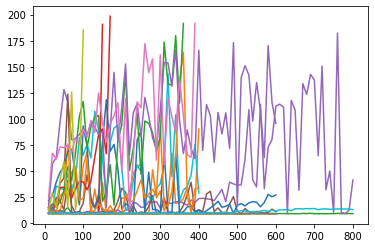

In [ ]:
def objectiveDQN(trial):
    pms = Parameters()
    pms.buf_size=trial.suggest_categorical('buffer', [x for x in range(1000, 10000, 1000)])
    pms.batch=trial.suggest_categorical('batch', [64,128,256,512])
    pms.epoch=10
    pms.max_ep = trial.suggest_categorical('max_ep', [x for x in range(200, 1000, 200)]) 
    pms.eps =trial.suggest_float("eps", 0.1, 0.9, log=True)
    pms.gamma = trial.suggest_float("gamma", 0.5, 1, log=True)
    pms.C = trial.suggest_categorical('C', [x for x in range(25,150,25)]) 
    pms.lr = trial.suggest_float("lr", 1e-3, 1e-1, log=True)
    pms.opt = trial.suggest_categorical('opt', [Optimizer.ADAM,Optimizer.RMSPROP,Optimizer.SGD])
    dqn = Dqn(pms)
    ep_ids, returns = dqn.train_function()
    plt.plot(ep_ids, returns)
    returns=dqn.evaluation(video=False)
    dqn.close()   

    return returns

studyDQN = optuna.create_study(direction='maximize')
studyDQN.optimize(objectiveDQN, n_trials=20)

In [ ]:
optuna.visualization.plot_param_importances(studyDQN)

This shows us that chaning the buffer size was somewhat important to give us better results, higher batch size was prefered. 

In [ ]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning:

plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.



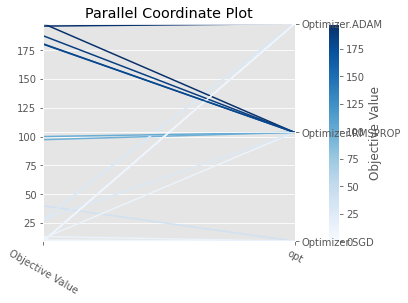

In [ ]:
optuna.visualization.matplotlib.plot_parallel_coordinate(studyDQN, params=['opt'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning:

plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.



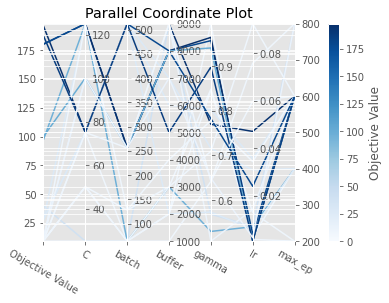

In [ ]:
optuna.visualization.matplotlib.plot_parallel_coordinate(studyDQN, params=['buffer','batch','max_ep','C',"lr", "gamma"])

From the above parallel coordinate plot we can observe the values of hyperparameters which were prefered for optimal results. We can see most of values are somewhat around the default values. Even though only 20 trials were run but we can have a better idea if we run more trials.